<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#PCoA" data-toc-modified-id="PCoA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PCoA</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#CCA" data-toc-modified-id="CCA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>CCA</a></span><ul class="toc-item"><li><span><a href="#Model1" data-toc-modified-id="Model1-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Model1</a></span></li><li><span><a href="#Model2" data-toc-modified-id="Model2-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Model2</a></span></li><li><span><a href="#Model2-sens" data-toc-modified-id="Model2-sens-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Model2-sens</a></span></li><li><span><a href="#Model3" data-toc-modified-id="Model3-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Model3</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Beta div ordinations with metadata mapped on


# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/'

# microbiome
## 16S-arch phyloseq object (one sample per species)
physeq_arch_SpecD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_SpecD.RDS'
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD.RDS'

# diversity
beta_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/diversity-qiime2/beta_div_genus.RDS'

# host tree
host_tree_SpecD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch.nwk'
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# params
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
library(data.table)
library(tidytable)
library(ape)
library(vegan)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘tidytable’


The following object is masked from ‘package:stats’:

    dt


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [3]:
df.dims()
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/ 


## Functions

In [4]:
#' Ordering distance matrixes
#' d = distance matrix (dist class)
#' x = vector to order dist by
dist_mtx_order = function(d, x){
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

In [5]:
pcoa = function(id, dist_list, make_plot=TRUE){
    # making PCoA plot 
    # id = list name
    # dist_list = list of distance matrixes
    # make_plt = create plot?
    
    d = dist_list[[id]]
    # using cmdscale for getting PCoA 
    r = cmdscale(d, eig=TRUE)
    perc_var_exp = r$eig / sum(r$eig)
    
    x = as.data.frame(r$points)
    x$sampleID = id
    r$points = x
    
    if(make_plot){
        options(repr.plot.width=4, repr.plot.height=3.5)
        x = 1:5
        plot(x, perc_var_exp[x], main=id)
    }
    
    return(r)
}

In [6]:
#' function for making ggplot2 plots
plot_pcoa = function(df, x_color='class', x_lab='PC1', y_lab='PC2'){
    df = df %>%
        mutate(D = case_when(D == 'jaccard' ~ 'Jaccard',
                             D == 'bray_curtis' ~ 'Bray-Curtis',
                             D == 'unweighted_unifrac' ~ 'unweighted UniFrac',
                             D == 'weighted_unifrac' ~ 'weighted UniFrac'))                      
    AES = aes_string('PC1', 'PC2', color=x_color)
    ggplot(df, AES) +
        geom_point(alpha=0.5) +
        facet_wrap(~ D, scales='free') +
        labs(x=x_lab, y=y_lab) +
        theme_bw() +
        theme(
            legend.title=element_text(size=12),
            legend.text=element_text(size=12)
        )

}

In [7]:
#' converting distance to data.frame
get_points = function(mds_list){
    # pulling out PCoA points
    df = mds_list$points %>% as.data.frame
    df$Sample = rownames(df)
    return(df)
}

# Load

In [8]:
# phyloseq
physeq_arch_SpecD = readRDS(physeq_arch_SpecD_file)
physeq_arch_SpecD

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1151 taxa and 110 samples ]
sample_data() Sample Data:       [ 110 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 1151 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1151 tips and 1150 internal nodes ]

In [9]:
# phyloseq
physeq_arch_IndD = readRDS(physeq_arch_IndD_file)
physeq_arch_IndD

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1891 taxa and 185 samples ]
sample_data() Sample Data:       [ 185 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 1891 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1891 tips and 1888 internal nodes ]

In [10]:
# beta diversity
beta_d = readRDS(beta_div_file)
beta_d %>% length

[1] 4

In [11]:
# host tree
host_tree = read.tree(host_tree_IndD_file)
host_tree


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

In [12]:
# metadata (IndD)
meta = physeq_arch_IndD %>% sample_data %>% as.matrix %>% as.data.table
meta

SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,CH4_kJ.d_mean,CH4_kJ.d_sd,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,2066.94152,1075.50477,52.2413228,27.1830584,0.4858472,0.16869553,38.6711742,21.3016201,2066.94152,1075.50477
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,431,Steppenzebra,Quagga,Equus_quagga,NA,89252,Mammalia,Perissodactyla,Equidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# PCoA

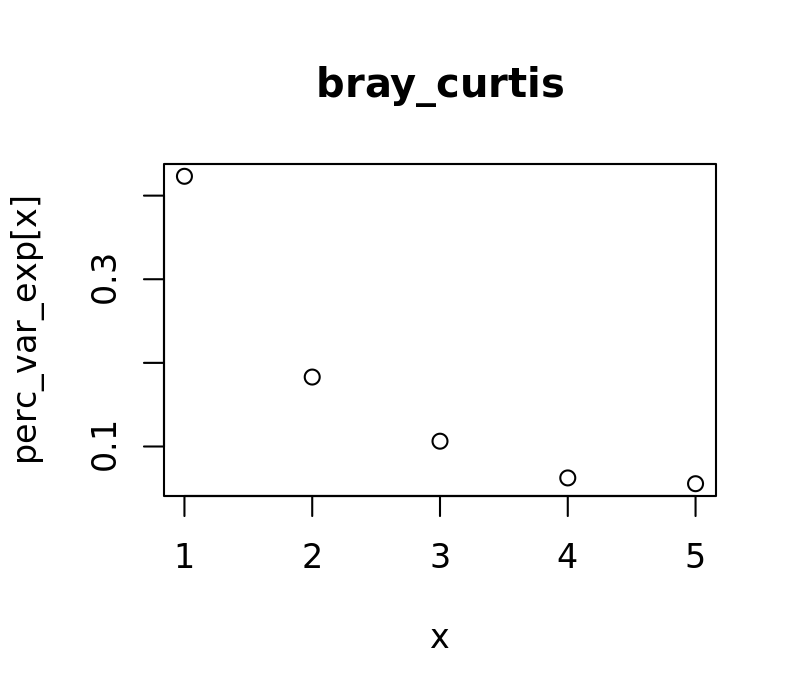

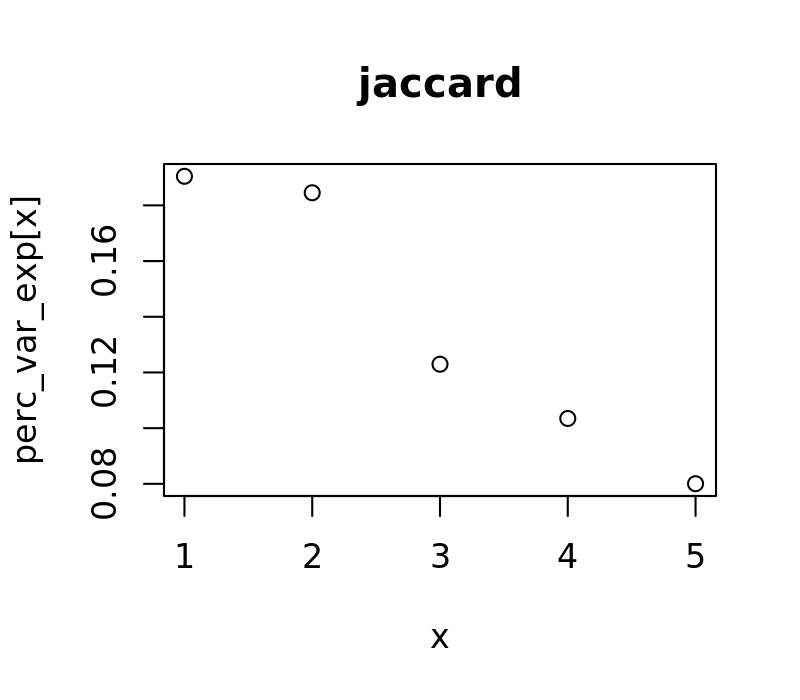

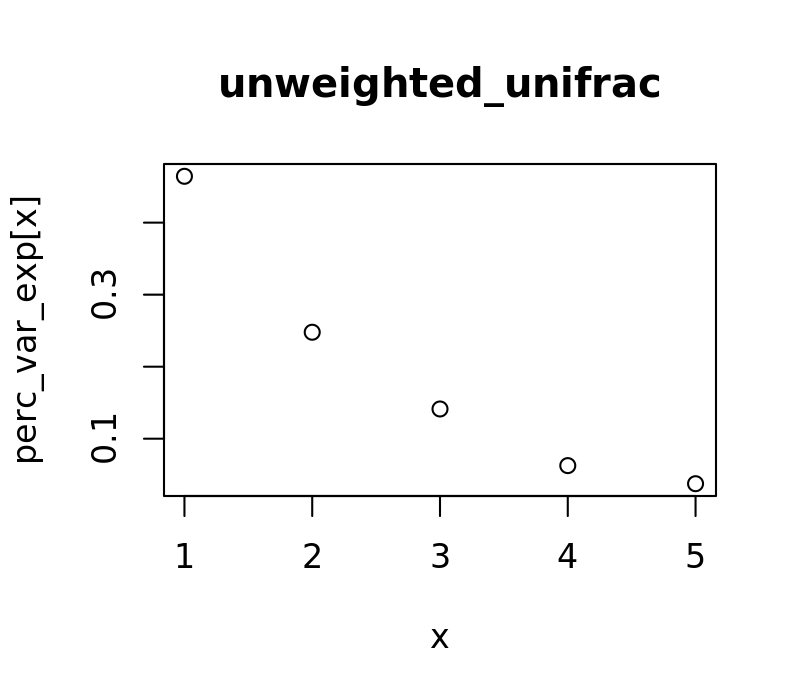

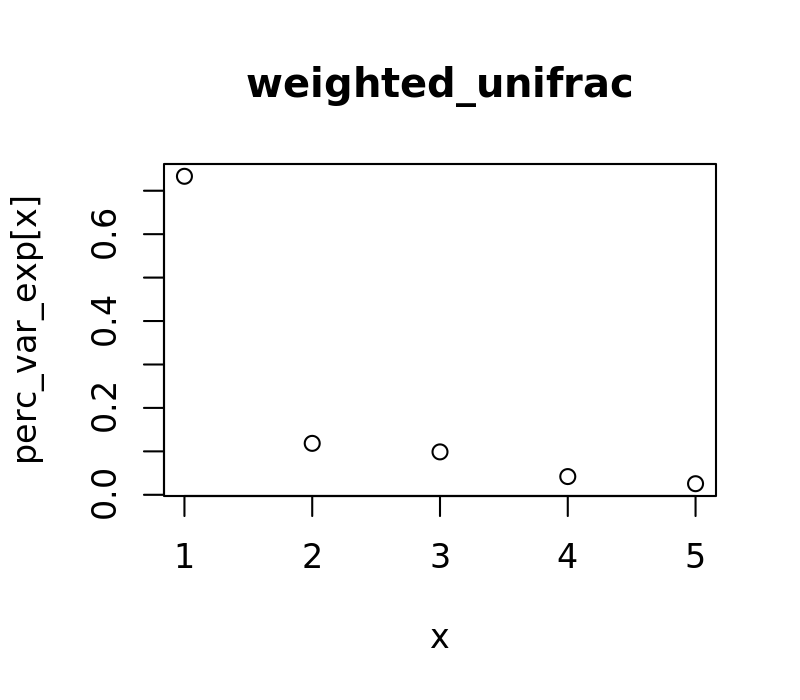

In [13]:
p.dims(4,2.5)
d_pcoa = plyr::llply(names(beta_d), pcoa, dist_list=beta_d)

## Plotting

In [14]:
# coverting to data.frame
get_points = function(mds_list){
    # pulling out PCoA points
    df = mds_list$points %>% as.data.frame
    df$Sample = rownames(df)
    return(df)
}

mds = plyr::ldply(d_pcoa, get_points)
colnames(mds) = c('PC1', 'PC2', 'D', 'Sample')

# status
mds

PC1,PC2,D,Sample
<dbl>,<dbl>,<chr>,<chr>
0.1208262,-0.2262896,bray_curtis,F14_Common_Bream
-0.2981791,-0.1792220,bray_curtis,F35_Red_Deer
⋮,⋮,⋮,⋮
1.5130192,-0.142210002,weighted_unifrac,X431_Quagga
-0.4745075,0.005165221,weighted_unifrac,X67_European_Roe


In [15]:
# joining with metadata
mds_j = mds %>%
    inner_join(meta %>% as.data.frame, c('Sample'='SampleID')) 

mds_j$Sample %>% unique %>% length %>% print
mds_j 

[1] 185


PC1,PC2,D,Sample,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,⋯,CH4_kJ.d_mean,CH4_kJ.d_sd,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.1208262,-0.2262896,bray_curtis,F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.2981791,-0.1792220,bray_curtis,F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,⋯,2066.94152,1075.50477,52.2413228,27.1830584,0.4858472,0.16869553,38.6711742,21.3016201,2066.94152,1075.50477
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.5130192,-0.142210002,weighted_unifrac,X431_Quagga,431,Steppenzebra,Quagga,Equus_quagga,NA,89252,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.4745075,0.005165221,weighted_unifrac,X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [16]:
dists_to_use = c('unweighted_unifrac', 'weighted_unifrac',                 
                 'bray_curtis', 'jaccard')

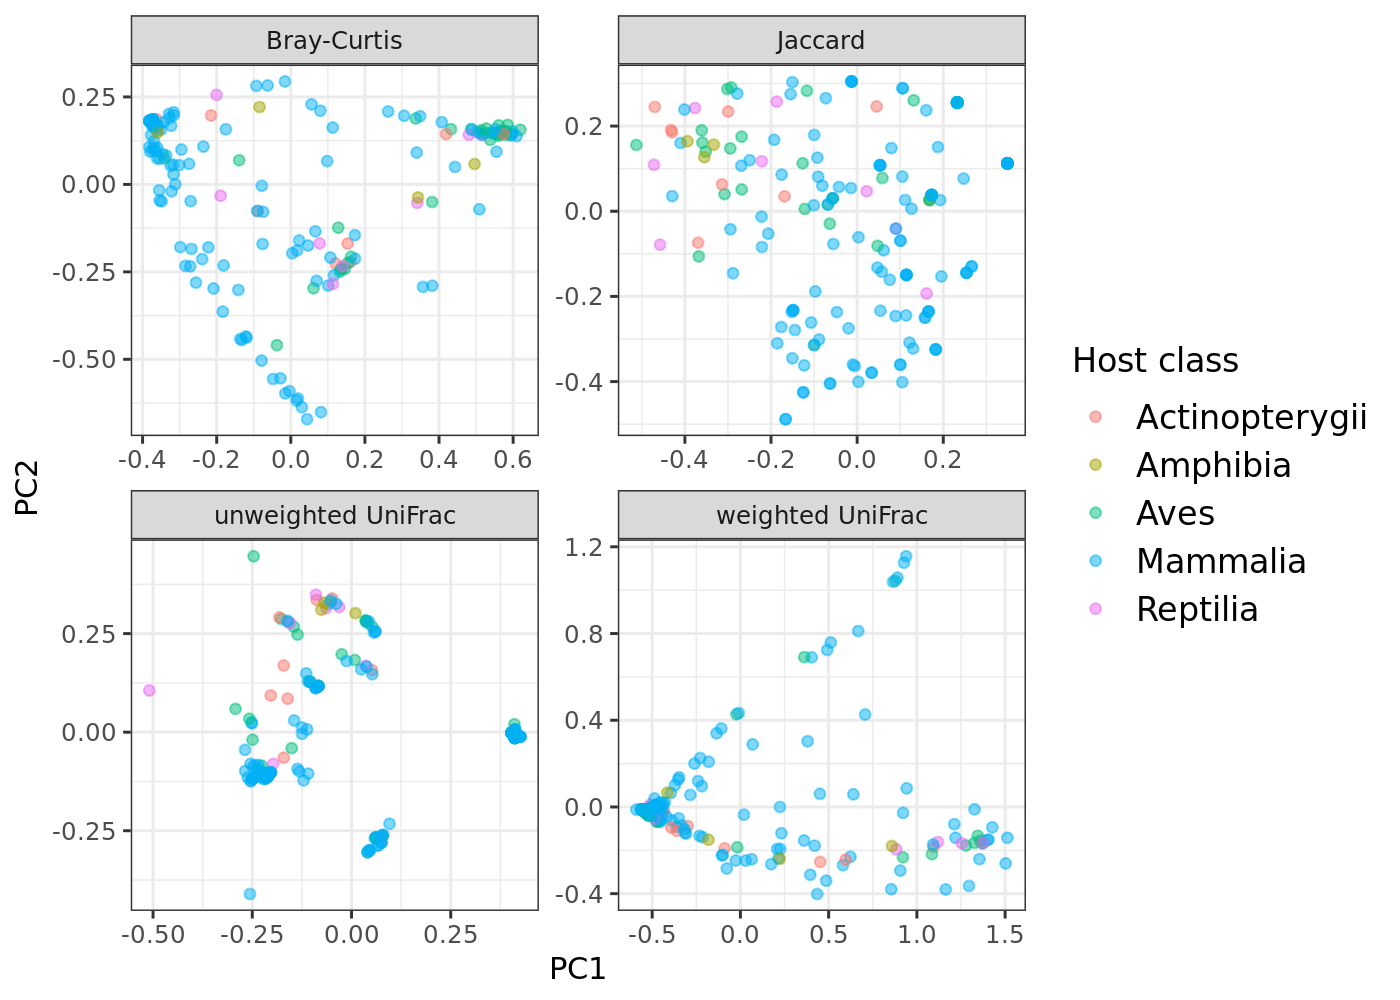

In [17]:
# taxonomy
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use)) +
    scale_color_discrete('Host class')
p.dims(7,5)
plot(p)

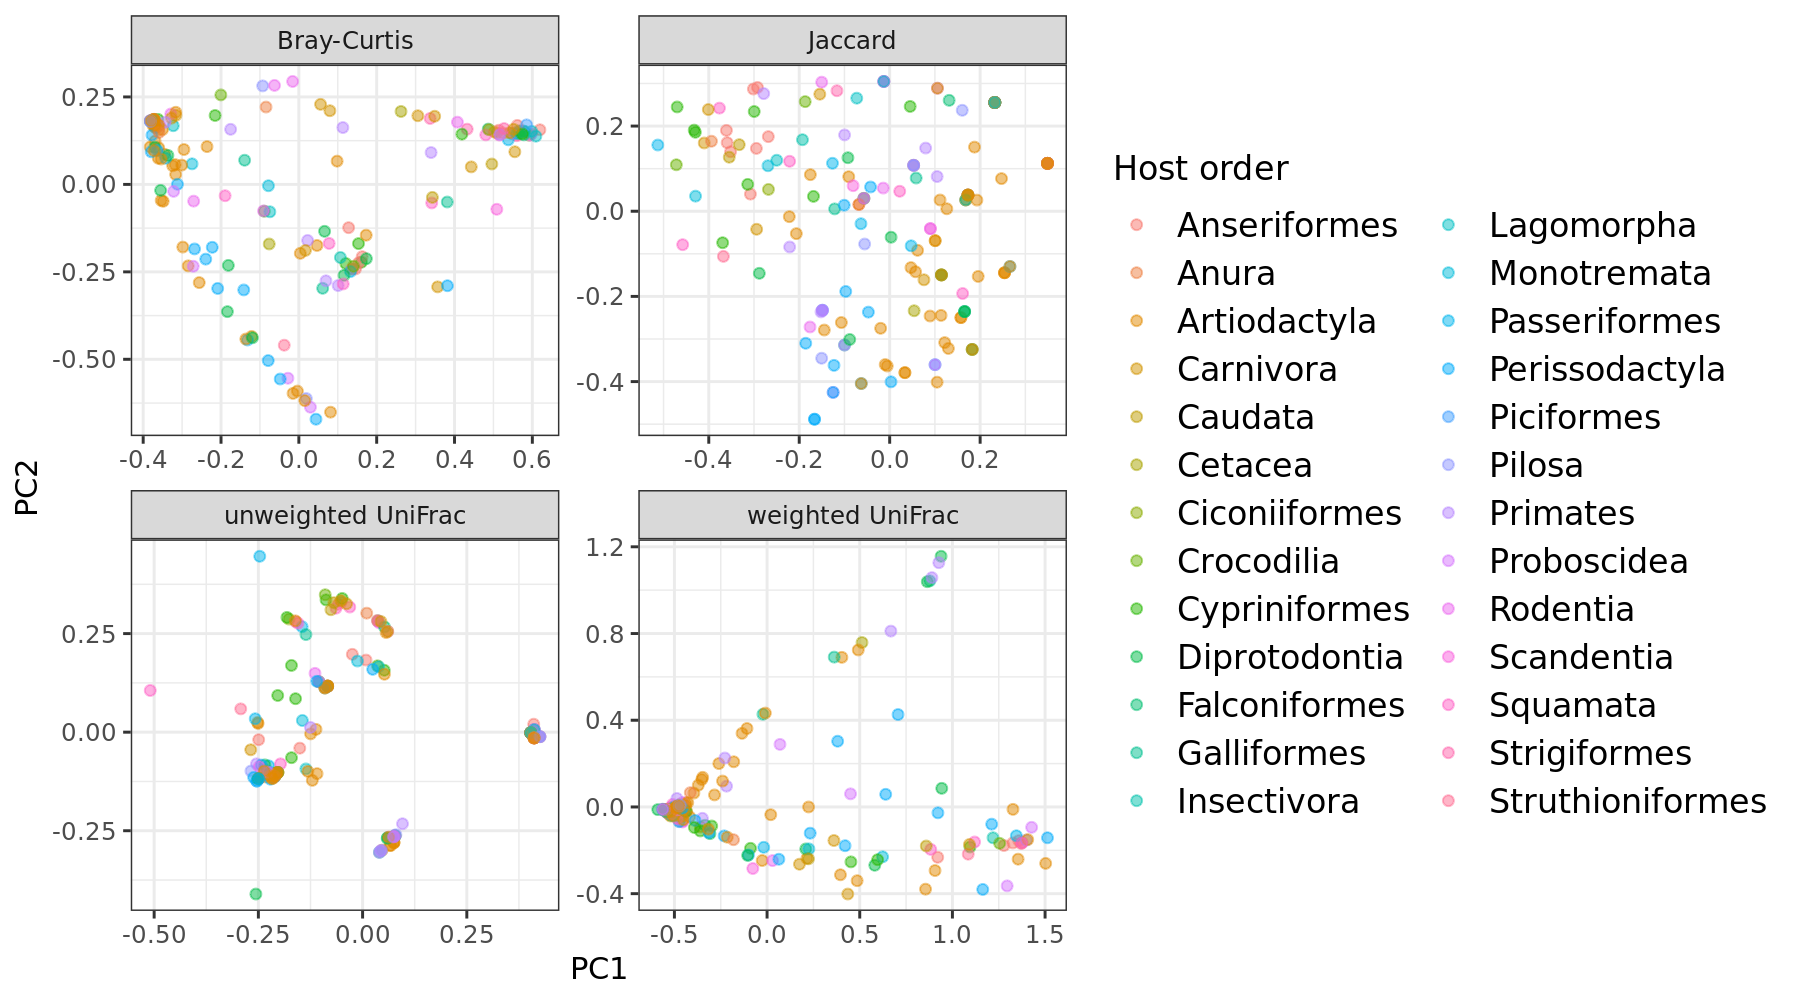

In [18]:
# taxonomy
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use), 'order') +
    scale_color_discrete('Host order')
p.dims(9,5)
plot(p)

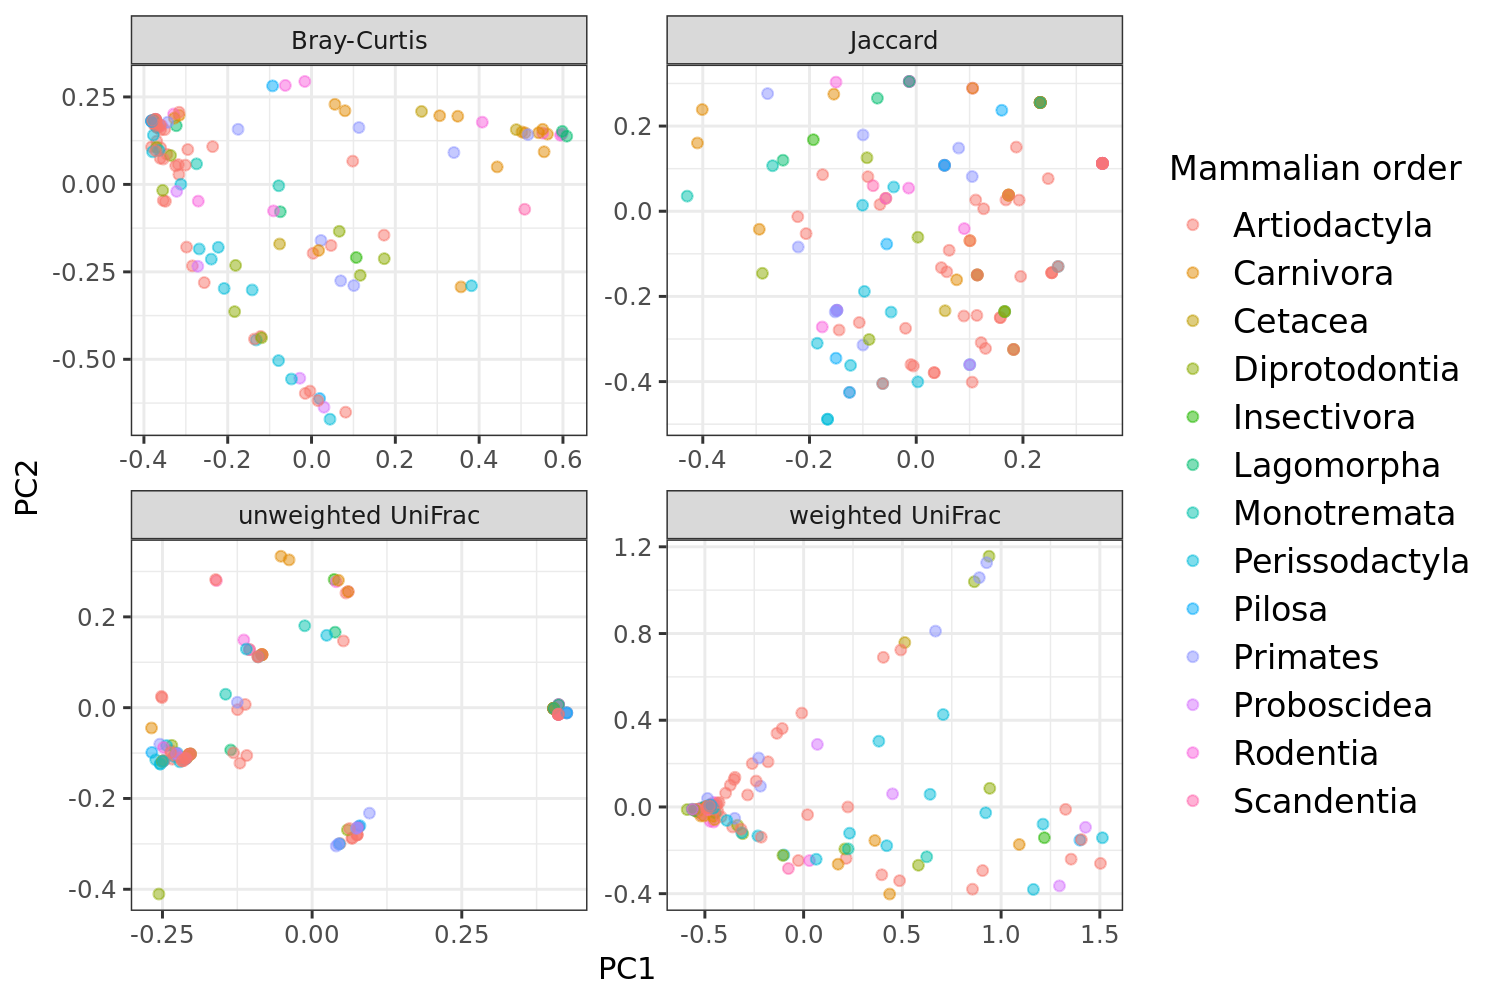

In [19]:
# taxonomy
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use, class == 'Mammalia'), 'order') +
    scale_color_discrete('Mammalian order')
p.dims(7.5,5)
plot(p)

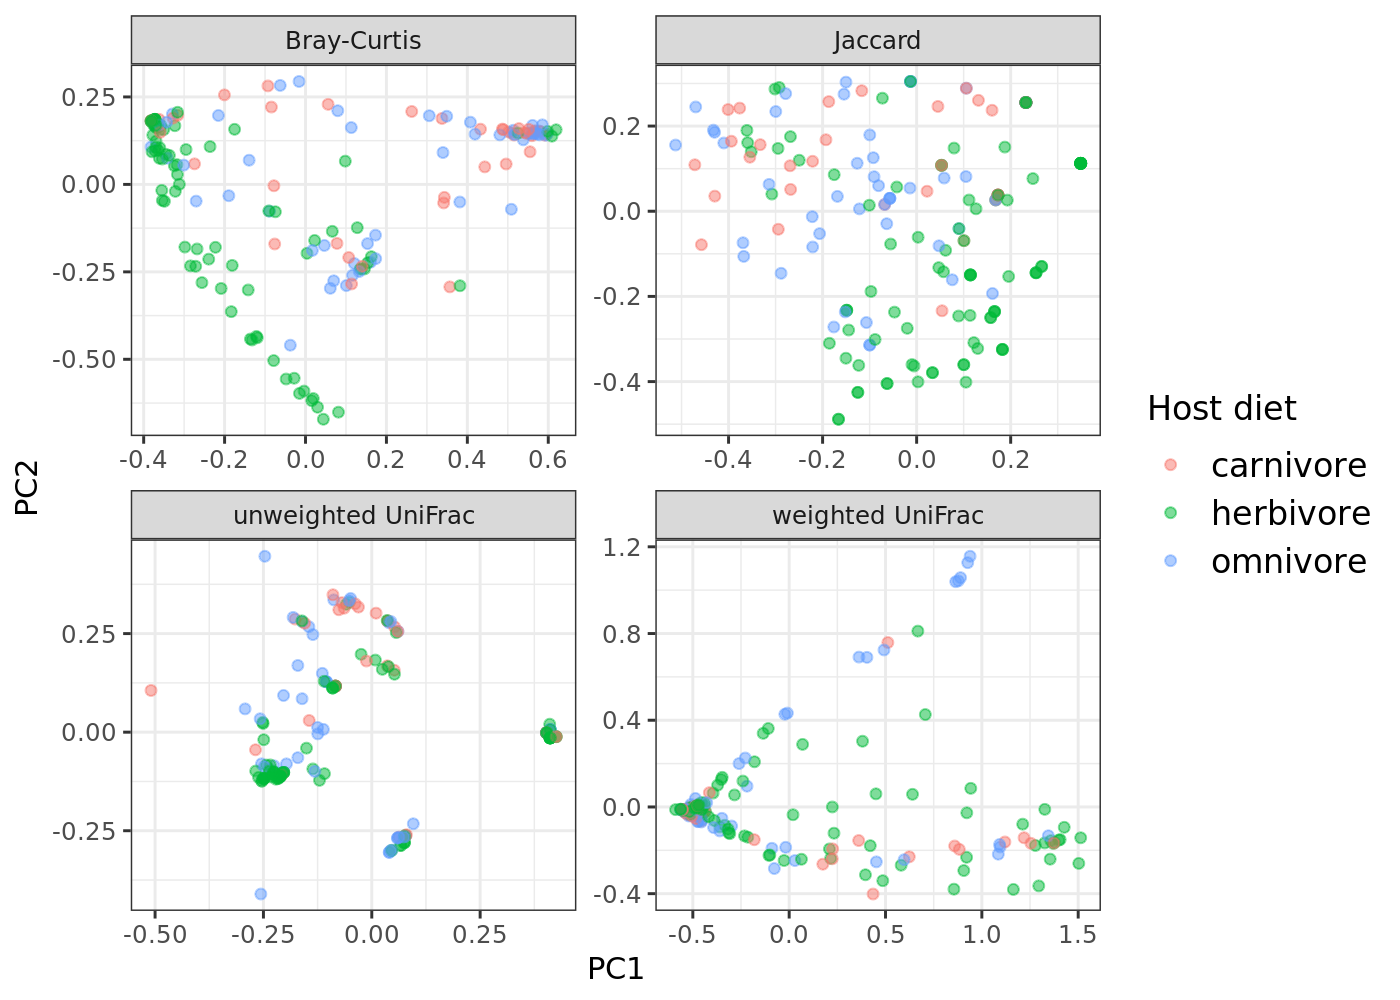

In [20]:
# diet
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use), 'diet') +
    scale_color_discrete('Host diet')
p.dims(7,5)
plot(p)

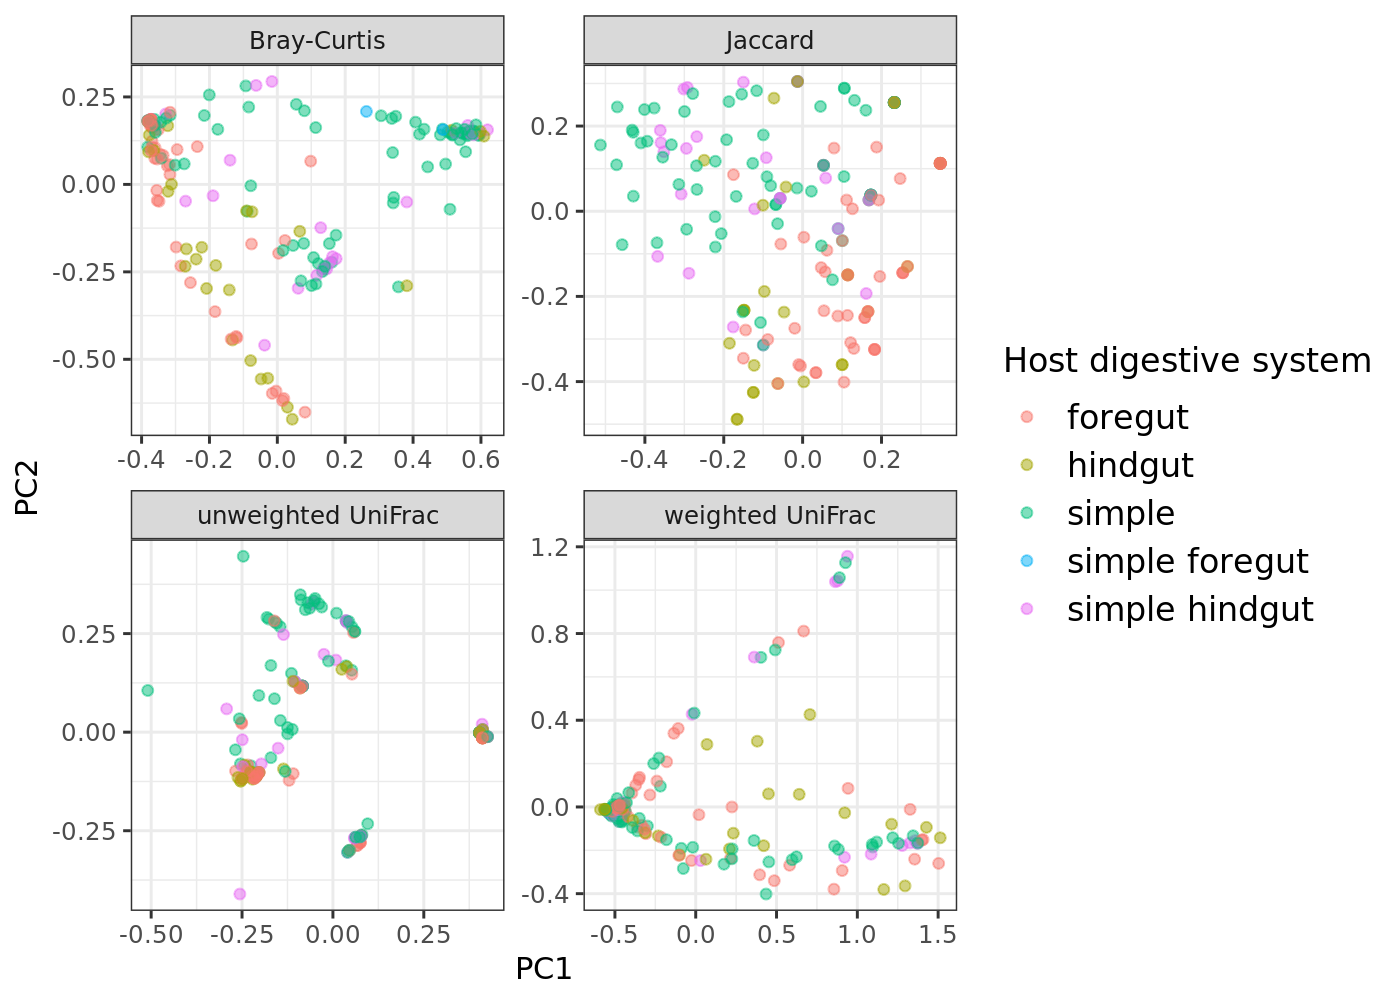

In [21]:
# digestive system
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use) %>% 
              mutate(digestive_system = ifelse(digestive_system == 'fermentation activity foregut', 
                                               'foregut', digestive_system)), 
              'digestive_system') +
    scale_color_discrete('Host digestive system')
p.dims(7,5)
plot(p)

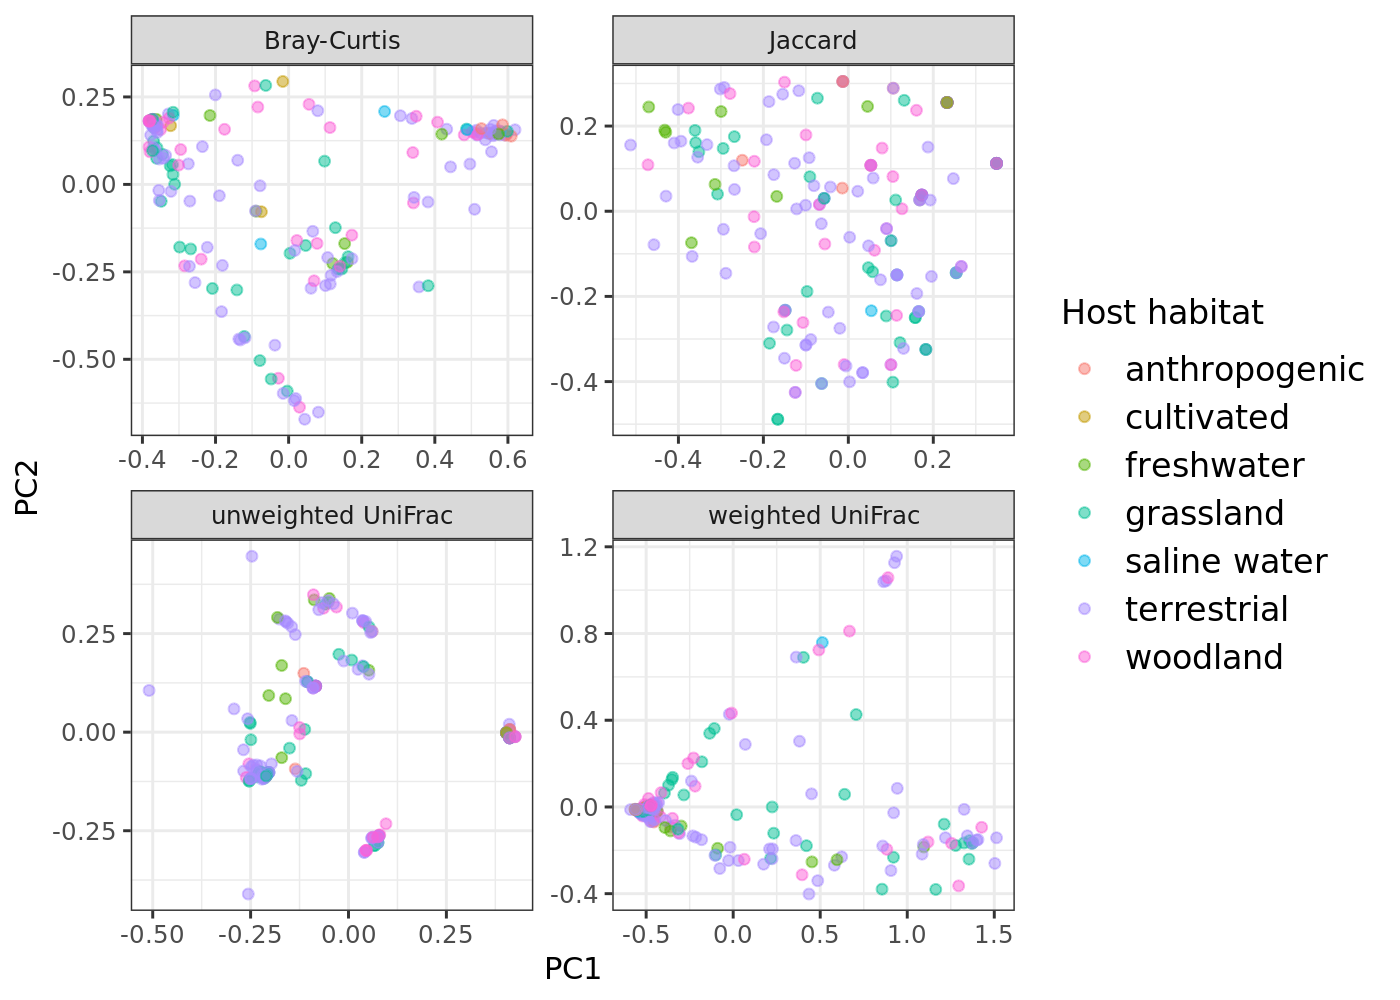

In [22]:
# captive/wild
p = plot_pcoa(mds_j %>% 
                  filter(D %in% dists_to_use) %>% 
                  mutate(habitat = gsub(' habitat', '', habitat_detail)), 
              'habitat') +
    scale_color_discrete('Host habitat')
p.dims(7,5)
plot(p)

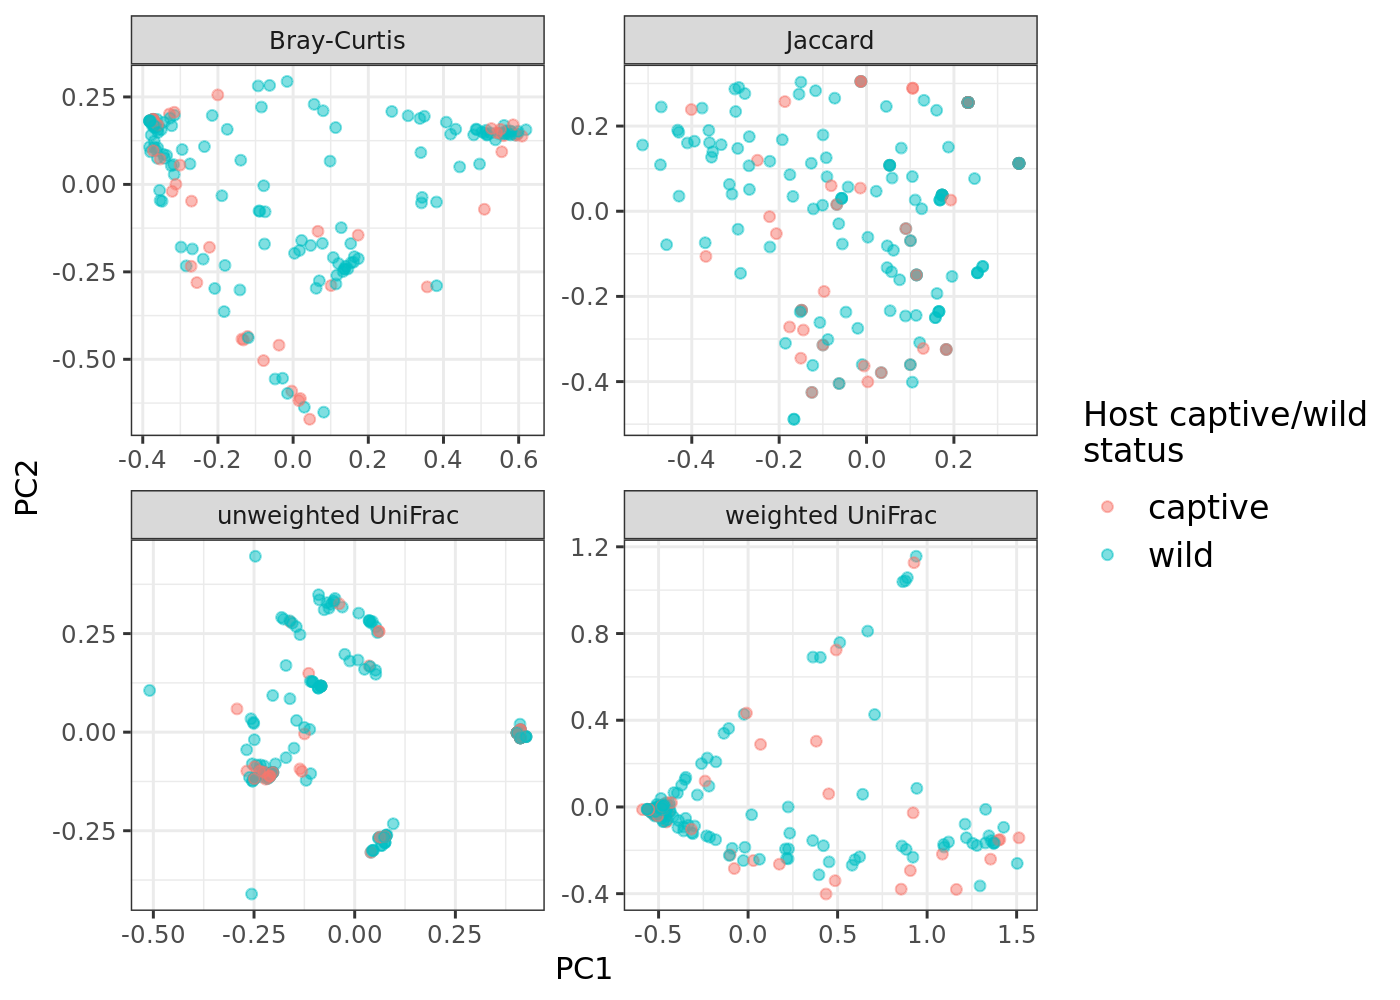

In [23]:
# captive/wild
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use), 'captive_wild') +
    scale_color_discrete('Host captive/wild\nstatus')
p.dims(7,5)
plot(p)

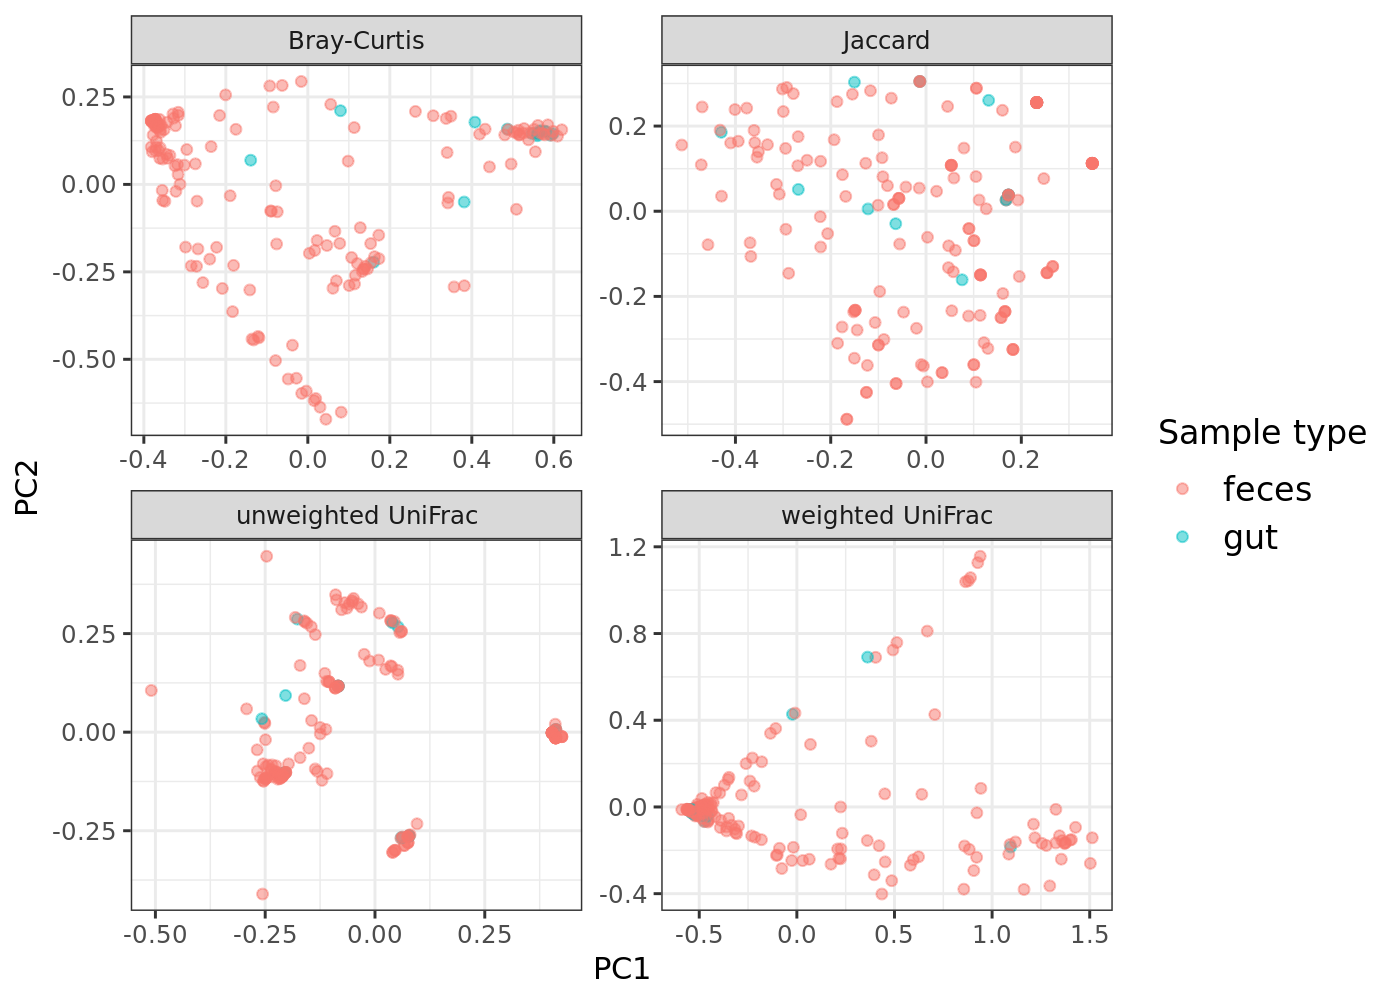

In [24]:
# sample_type
p = plot_pcoa(mds_j %>% filter(D %in% dists_to_use), 'sample_type') +
    scale_color_discrete('Sample type')
p.dims(7,5)
plot(p)

# CCA

In [25]:
library(CCA)

Loading required package: fda

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘fda’


The following object is masked from ‘package:lattice’:

    melanoma


The following object is masked from ‘package:graphics’:

    matplot


Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps

See https://github.com/NCAR/Fields for
 an ext

In [26]:
# sample x taxonomy matrix
x = physeq_arch_IndD %>%
    phyloseq2df(otu_table, long=TRUE)

y = physeq_arch_IndD %>%
    phyloseq2df(tax_table)

x = x %>%
    inner_join(y, c('OTU')) %>%
    mutate(Taxonomy = paste(Phylum, Class, Order, sep='-')) %>%
    group_by(Sample, Taxonomy) %>%
    summarize(Count = sum(Count)) %>%
    ungroup() %>%
    spread(Taxonomy, Count) %>%
    as.data.frame
rownames(x) = x$Sample
x$Sample = NULL

# total sum scaling
x = t(apply(x, 1, function(y) y / sum(y)))
          
# summary
rowSums(x) %>% summary
colSums(x) %>% summary
x

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.00097   0.00835   0.05636   7.70833   0.94255 132.09755 

,Asgardaeota-Odinarchaeia-unclassified,Crenarchaeota-Bathyarchaeia-unclassified,Crenarchaeota-Bathyarchaeia-uncultured euryarchaeote,Crenarchaeota-Bathyarchaeia-uncultured Thermoproteales archaeon,Crenarchaeota-Bathyarchaeia-unidentified archaeon,Diapherotrites-Iainarchaeia-Iainarchaeales,Euryarchaeota-Halobacteria-Halobacteriales,Euryarchaeota-Methanobacteria-Methanobacteriales,Euryarchaeota-Methanomicrobia-Methanocellales,Euryarchaeota-Methanomicrobia-Methanomicrobiales,⋯,Euryarchaeota-Thermoplasmata-Marine Group II,Euryarchaeota-Thermoplasmata-Methanomassiliicoccales,Euryarchaeota-unclassified-unclassified,Nanoarchaeaeota-Woesearchaeia-archaeon GW2011_AR15,Nanoarchaeaeota-Woesearchaeia-Candidatus Diapherotrites archaeon ADurb.Bin253,Nanoarchaeaeota-Woesearchaeia-Candidatus Staskawiczbacteria bacterium RIFOXYA2_FULL_32_7,Nanoarchaeaeota-Woesearchaeia-unclassified,Nanoarchaeaeota-Woesearchaeia-uncultured euryarchaeote,Thaumarchaeota-Nitrososphaeria-Nitrosopumilales,Thaumarchaeota-Nitrososphaeria-Nitrososphaerales
F14_Common_Bream,0,0.00318195,0.0008678045,0,0,0,0,0.7558577,0.001446341,0.0326873,⋯,0,0.00462829,0,0,0,0,0.0005785363,0,0,0.0000000
F157a_European_Toad,0,0.00000000,0.0000000000,0,0,0,0,0.7835821,0.000000000,0.0000000,⋯,0,0.00000000,0,0,0,0,0.0000000000,0,0,0.2164179
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X95_Meadow_Viper,0,0,0,0,0,0,0,0,0,0.03497164,⋯,0,0.007561437,0,0,0,0,0,0,0,0.9574669
X96_European_Hare,0,0,0,0,0,0,0,1,0,0.00000000,⋯,0,0.000000000,0,0,0,0,0,0,0,0.0000000


## Model1

In [27]:
# metadata
## class
Y_class = meta %>%
    dplyr::select(SampleID, class) %>%
    mutate(Z = 1) %>%
    spread(class, Z, fill=0) %>%
    as.data.frame
rownames(Y_class) = Y_class$SampleID
Y_class$SampleID = NULL

## diet
diet_cols = c('diet_vertebrate', 'diet_invertebrate', 'diet_fruit', 
              'diet_flowers_nectar_pollen', 'diet_leaves_branches_bark_buds', 
              'diet_seeds', 'diet_grass_waterplants', 'diet_roots_tubers')
Y_diet = meta %>%
    dplyr::select(SampleID, diet_vertebrate, diet_invertebrate, diet_fruit,
                  diet_flowers_nectar_pollen, diet_leaves_branches_bark_buds, diet_seeds,
                  diet_grass_waterplants, diet_roots_tubers) %>%
    mutate_at(diet_cols, function(x) ifelse(x == 'yes', 1, 0)) %>%
    as.data.frame
rownames(Y_diet) = Y_diet$SampleID
Y_diet$SampleID = NULL

## merge
Y = cbind(Y_class, Y_diet)
Y = Y[rownames(x),]
Y

,Actinopterygii,Amphibia,Aves,Mammalia,Reptilia,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,1,0,0,0,0,0,1,0,0,0,0,1,0
F157a_European_Toad,0,1,0,0,0,0,0,1,0,1,1,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X95_Meadow_Viper,0,0,0,0,1,0,0,0,0,0,1,1,0
X96_European_Hare,0,0,0,1,0,0,0,1,0,1,1,1,0


In [28]:
# cca
X = as.data.frame(x)
cca_res = cca(X ~ Actinopterygii + Amphibia + Aves + Mammalia + Reptilia + diet_vertebrate + diet_invertebrate + diet_fruit + diet_flowers_nectar_pollen + diet_leaves_branches_bark_buds + diet_seeds + diet_grass_waterplants + diet_roots_tubers, Y)
cca_res

Call: cca(formula = X ~ Actinopterygii + Amphibia + Aves + Mammalia +
Reptilia + diet_vertebrate + diet_invertebrate + diet_fruit +
diet_flowers_nectar_pollen + diet_leaves_branches_bark_buds +
diet_seeds + diet_grass_waterplants + diet_roots_tubers, data = Y)

              Inertia Proportion Rank
Total          3.3537     1.0000     
Constrained    0.6677     0.1991   12
Unconstrained  2.6861     0.8009   21
Inertia is scaled Chi-square 
Some constraints were aliased because they were collinear (redundant)

Eigenvalues for constrained axes:
   CCA1    CCA2    CCA3    CCA4    CCA5    CCA6    CCA7    CCA8    CCA9   CCA10 
0.23711 0.16708 0.14801 0.06085 0.03416 0.01396 0.00236 0.00202 0.00111 0.00083 
  CCA11   CCA12 
0.00010 0.00007 

Eigenvalues for unconstrained axes:
   CA1    CA2    CA3    CA4    CA5    CA6    CA7    CA8 
0.7265 0.5249 0.4835 0.4219 0.2307 0.1191 0.0751 0.0423 
(Showing 8 of 21 unconstrained eigenvalues)


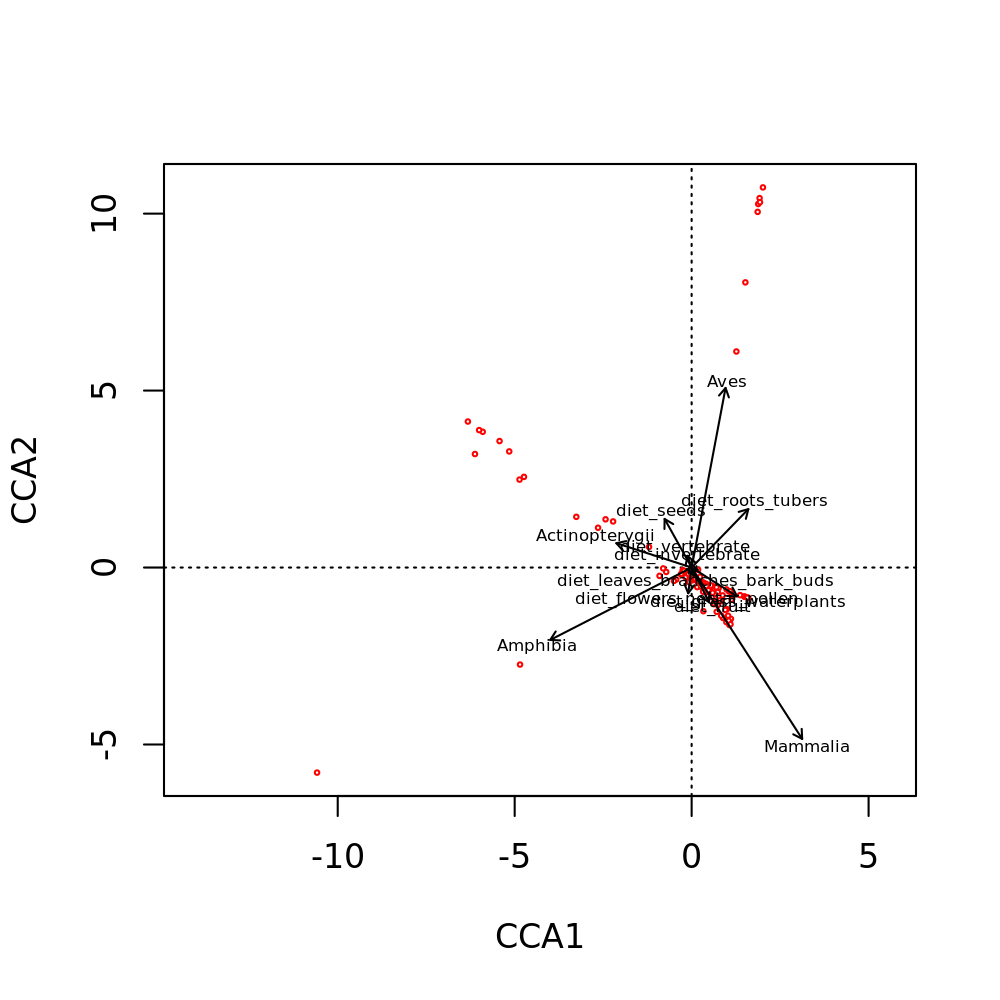

In [29]:
p.dims(5,5)
plot(cca_res, type="n")
points(cca_res, display = "sites", cex = 0.3, pch=21, col="red", bg="white")
text(cca_res, display="cn", cex=0.5)

In [30]:
anova(cca_res) 

,Df,ChiSquare,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,12,0.6676631,3.56279,0.001
Residual,172,2.6860517,NA,NA


In [31]:
df.dims(30)
anova(cca_res, by="term", permutations=999)
df.dims()

,Df,ChiSquare,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Actinopterygii,1,0.082757991,5.2993674,0.007
Amphibia,1,0.173718817,11.1239992,0.001
Aves,1,0.136394696,8.7339674,0.001
Mammalia,1,0.137418475,8.7995246,0.001
diet_vertebrate,1,0.017864759,1.1439611,0.333
diet_invertebrate,1,0.014337150,0.9180724,0.483
diet_fruit,1,0.014763592,0.9453794,0.446
diet_flowers_nectar_pollen,1,0.008615899,0.5517149,0.730
diet_leaves_branches_bark_buds,1,0.009105726,0.5830807,0.757


## Model2

In [32]:
# metadata
## class
Y = meta %>%
    dplyr::select(SampleID, class, diet, digestive_system, habitat, sample_type) %>%
    as.data.frame
rownames(Y) = Y$SampleID
Y$SampleID = NULL

Y = Y[rownames(x),]
Y

,class,diet,digestive_system,habitat,sample_type
,<chr>,<chr>,<chr>,<chr>,<chr>
F14_Common_Bream,Actinopterygii,omnivore,simple,aquatic habitat,feces
F157a_European_Toad,Amphibia,carnivore,simple,terrestrial habitat,feces
⋮,⋮,⋮,⋮,⋮,⋮
X95_Meadow_Viper,Reptilia,carnivore,simple,terrestrial habitat,feces
X96_European_Hare,Mammalia,herbivore,hindgut,terrestrial habitat,feces


In [33]:
# cca
X = as.data.frame(x)
cca_res = cca(X ~ class + diet + digestive_system + habitat + sample_type, Y)
cca_res

Call: cca(formula = X ~ class + diet + digestive_system + habitat +
sample_type, data = Y)

              Inertia Proportion Rank
Total          3.3537     1.0000     
Constrained    1.0046     0.2995   12
Unconstrained  2.3491     0.7005   21
Inertia is scaled Chi-square 

Eigenvalues for constrained axes:
  CCA1   CCA2   CCA3   CCA4   CCA5   CCA6   CCA7   CCA8   CCA9  CCA10  CCA11 
0.4210 0.2374 0.1479 0.0849 0.0595 0.0471 0.0053 0.0011 0.0003 0.0001 0.0000 
 CCA12 
0.0000 

Eigenvalues for unconstrained axes:
   CA1    CA2    CA3    CA4    CA5    CA6    CA7    CA8 
0.5379 0.4692 0.4396 0.3627 0.2405 0.1177 0.0755 0.0417 
(Showing 8 of 21 unconstrained eigenvalues)


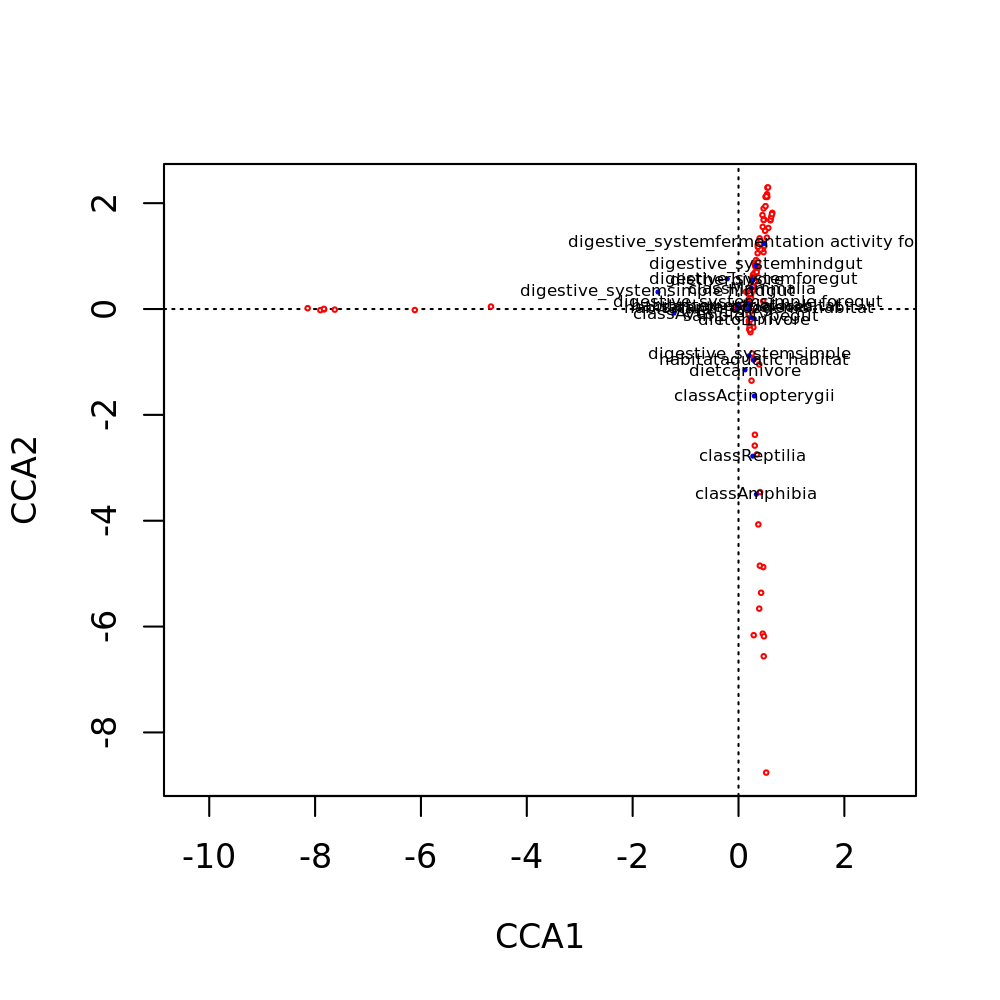

In [34]:
p.dims(5,5)
plot(cca_res, type="n")
points(cca_res, display = "sites", cex = 0.3, pch=21, col="red", bg="white")
points(cca_res, display="cn", cex=0.2, col='blue', pch=19)
text(cca_res, display="cn", cex=0.5)

In [35]:
df.dims(30)
anova(cca_res, by="term", permutations=999)
df.dims()

,Df,ChiSquare,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
class,4,0.53028998,9.5939432,0.001
diet,2,0.16093404,5.8231991,0.001
digestive_system,5,0.28168949,4.0770342,0.005
habitat,2,0.01484400,0.5371118,0.585
sample_type,1,0.01683725,1.2184703,0.295
Residual,170,2.34912002,NA,NA


## Model2-sens

* 1-per host speces sensitivity analysis

In [36]:
# creating sample replicates
one_per_spec = function(rep, meta){
    meta %>%
        dplyr::select(SampleID, scientific_name) %>%
        group_by(scientific_name) %>%
        sample_n(1) %>%
        .$SampleID
}

nreps = 1000
sample_list = 1:nreps %>%
    lapply(one_per_spec, meta=meta)

sample_list %>% length
sample_list %>% lapply(length) %>% unlist %>% summary

[1] 1000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    110     110     110     110     110     110 

In [37]:
#' function for running CCA
cca_per_rep = function(samples, A, B){
    X = A[samples,]
    Y = B[samples,]
    res = cca(X ~ class + diet + digestive_system + habitat + sample_type, Y)
    res = anova(res, by="term", permutations=999)
    res$term = rownames(res)
    return(res)
}

In [38]:
# running cca + anova
cca_res = sample_list %>%
    lapply(cca_per_rep, A=as.data.frame(x), B=Y) %>%
    data.table::rbindlist(use.names=TRUE, idcol='rep')
colnames(cca_res) = c('rep', 'df', 'chisq', 'F', 'P', 'term')
cca_res

rep,df,chisq,F,P,term
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4,0.3190988,3.184496,0.004,class
1,2,0.1090148,2.175860,0.011,diet
⋮,⋮,⋮,⋮,⋮,⋮
1000,1,0.01781248,0.6514816,0.648,sample_type
1000,95,2.59744200,NA,NA,Residual


In [39]:
# summarizing
cca_res_s = cca_res %>%
    dt_summarize(F_mean = mean(F),
                 P_all = 1 - (sum(P < 0.05) / length(P)),
                 by=c(term))

df.dims(10)
cca_res_s
df.dims()

term,F_mean,P_all
<chr>,<dbl>,<dbl>
class,3.5414816,0.000
diet,2.0649336,0.219
digestive_system,1.4070994,0.994
habitat,0.3402145,1.000
sample_type,0.5624858,1.000
Residual,NA,NA


## Model3

# sessionInfo

In [40]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-phy/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] CCA_1.2           fields_10.3       maps_3.3.0        spam_2.5-1       
 [5] dotCall64_1.0-0   fda_5.1.4         Matrix_1.2-18     LeyLabRMisc_0.1.5
 [9] vegan_2.5-6       lattice_0.20-38   permute_0.9-5     ape_5.3          
[13] tidytable_0.4.1   data.table_